In [1]:
import numpy as np

def generate_toy_gaussian_data(n_samples=200):
    mean = [0, 0]
    cov = [[1, 0.5], [0.5, 1]]
    X = np.random.multivariate_normal(mean, cov, n_samples)
    return X

X = generate_toy_gaussian_data()


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch

np.random.seed(42)
true_mean = np.array([2.0, -2.0])
true_cov = np.eye(2)
n_samples = 100
X_data = np.random.multivariate_normal(true_mean, true_cov, size=n_samples)

In [5]:
def log_posterior(mu, X, prior_var=1.0, obs_var=1.0):
    """
    Log posterior up to constant:
    log p(mu) + sum log p(x_i | mu)
    """
    prior = -0.5 * (mu**2).sum(-1) / prior_var
    likelihood = -0.5 * ((X[:, None, :] - mu[None, :, :])**2).sum(-1) / obs_var
    return prior + likelihood.sum(0)

In [6]:
n_particles = 50
particles = torch.randn(n_particles, 2, requires_grad=True)

optimizer = torch.optim.Adam([particles], lr=0.05)
bandwidth = 1.0

for it in range(200):
    optimizer.zero_grad()
    with torch.enable_grad():
        logp = log_posterior(particles, torch.tensor(X_data, dtype=torch.float32))
        logp.sum().backward()
        grad_logp = particles.grad.clone()

    with torch.no_grad():
        sq_dists = ((particles[:, None, :] - particles[None, :, :])**2).sum(-1)
        K = torch.exp(-sq_dists / (2 * bandwidth**2))
        grad_K = -torch.einsum('ij,ijk->ijk', K, (particles[:, None, :] - particles[None, :, :])) / bandwidth**2

        phi = (K @ grad_logp) / n_particles + grad_K.sum(0) / n_particles

    particles.grad = -phi
    optimizer.step()

    if it % 50 == 0:
        print(f"Iteration {it}")

Iteration 0
Iteration 50
Iteration 100
Iteration 150


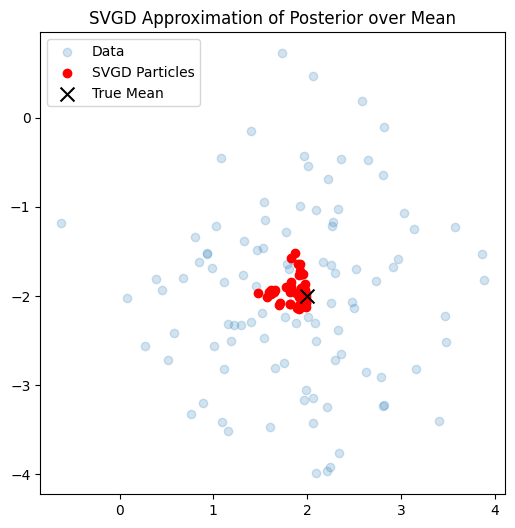

In [7]:
particles_np = particles.detach().numpy()
plt.figure(figsize=(6, 6))
plt.scatter(X_data[:,0], X_data[:,1], alpha=0.2, label='Data')
plt.scatter(particles_np[:,0], particles_np[:,1], c='red', label='SVGD Particles')
plt.scatter(true_mean[0], true_mean[1], c='black', marker='x', s=100, label='True Mean')
plt.legend()
plt.title("SVGD Approximation of Posterior over Mean")
plt.show()